# **1. Import and Define**
ในขั้นแรกเป็นการ import ตัว library ต่างๆ และกำหนดค่าตัวแปรที่ต้องใช้

In [ ]:
#กดรัน2 รอบ
!pip install keras==2.2.5
%tensorflow_version 1.x

  Using cached Keras-2.2.5-py2.py3-none-any.whl (336 kB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold


from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = ('/content/drive/MyDrive/Project Vision')

ROOT_DIR = ('/content')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 49
IMAGE_SIZE = 512

# **2. Download Libraries and Pretrained Weights**
ในที่นี้ เราได้เลือกเป็น Mask R-CNN ของบริษัท Matterport  ก็จะทำการดาวน์โหลด library ตัวนี้มา รวมทั้งดาวน์โหลด pretrained weight ที่มีให้ด้วย

In [ ]:
os.getcwd()

'/content'

In [ ]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

# no idea
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 28.96 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [ ]:
os.getcwd()

'/content/Mask_RCNN'

In [ ]:
sys.path.append('/content/Mask_RCNN')

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
# Download COCO pre-trained weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [ ]:
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# now I do not have to start my training from the beginning.
# I can simply change my weights path to the last weights file e.g. ‘mask_rcnn_object_0003.h5’.

# Skip detections with < 90% confidence
# DETECTION_MIN_CONFIDENCE = 0.9

# **3. Set Config**
โมเดล Mask R-CNN จะมี hyperparameter ให้ปรับได้มาก ในที่นี้ได้ทำการปรับแค่บางตัว สำหรับ hyperparameter ทั้งหมด เช่น     STEPS_PER_EPOCH = 110 ,  VALIDATION_STEPS = 2 เป็นต้น

In [ ]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 สำหรับคลาส background

    GPU_COUNT = 1
    IMAGES_PER_GPU = 4



    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 100

    # เนื่องจาก Kaggle จำกัดเวลาในการรัน kernel ไว้ 9 ชั่วโมง
    # เราจึงกำหนดค่า STEPS_PER_EPOCH และ VALIDATION_STEPS ให้รันทันในเวลานี้ครับ
   # STEPS_PER_EPOCH = 5500
  #  VALIDATION_STEPS = 100

    #เป็นการตั้งต่าในการเรียนรู้ต่อรอบการ Train
    STEPS_PER_EPOCH = 200
#step ของการตรวจสอบ
    VALIDATION_STEPS = 75


config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                62
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# **4. Prepare Datasets**
ขั้นตอนต่อไปเป็นการอ่าน dataset โดยเริ่มจากไฟล์ label_descriptions.json ซึ่งบอกข้อมูลของ label โดยเราจะเก็บชื่อของ category ไว้ใช้อ้างอิงและแสดงผล

In [ ]:
with open("/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/new_label_descriptions3.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

ไฟล์ข้อมูลหลักก็คือ train.csv ซึ่งแต่ละแถวคือแต่ละ mask และมีคอลัมน์ต่างๆ ดังนี้

* ImageId บอกชื่อไฟล์รูปภาพ
* EncodedPixels บอกว่า mask นี้ ประกอบด้วย pixel ใดบ้าง โดยเก็บข้อมูลในรูปแบบ run-length encoding
* Height บอกความสูงของรูปภาพ
* Width บอกความกว้างของรูปภาพ
* ClassId บอกประเภทเครื่องแต่งกายของ mask นี้


อธิบายเพิ่มเติ่มเกี่ยวกับ EncodedPixels และ ClassId

**EncodedPixels** เป็น run-length encoding คือจากภาพสองมิติ จะคลี่ออกมาเป็นมิติเดียว โดยไล่จากบนลงล่างก่อน แล้วถ้า mask ประกอบด้วย pixel ตำแหน่งที่ 10 ถึง 14 (คือจากตำแหน่งที่ 10 มี pixel ที่เป็น mask อยู่ติดกัน 4) และ 23 ถึง 29 (คือจากตำแหน่งที่ 23 มี pixel ที่เป็น mask อยู่ติดกัน 7) ก็จะเก็บค่าเป็น 10 4 23 7

**ClassId** ตัวเลขด้านหน้าสุดคือหมายเลข category จากนั้นจะคั่นด้วยเครื่องหมาย '_' แล้วตัวเลขถัดๆ ไป จะเป็นหมายเลข attribute โดยในที่นี้จะทำเฉพาะ category อย่างเดียวครับ

In [ ]:
segment_df = pd.read_csv("/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/newtrain_BAM.csv")
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))

segment_df.head()


Total segments:  1806


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,0002ec21ddb8477e98b2cbb87ea2e269.jpg,2673735 2 2676734 8 2679734 13 2682733 19 2685...,3000,1997,33,33
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,2287509 4 2290504 12 2290588 26 2293501 18 229...,3000,1997,10,10
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,3077799 43 3080792 52 3083786 60 3086779 70 30...,3000,1997,47,47
3,0002ec21ddb8477e98b2cbb87ea2e269.jpg,2678617 8 2681610 18 2684607 25 2687605 31 269...,3000,1997,47,47
4,00048c3a2fb9c29340473c4cfc06424a.jpg,239016 3 239989 6 240963 7 241938 8 242913 9 2...,975,650,13,13


In [ ]:
#ลดขนาดของไฟล์train
#segment_df = segment_df0.head(2500)
#segment_df.head()
#print("Total segments: ", len(segment_df))

ขั้นตอนถัดมาจะเป็นการรวมแถวที่เป็นรูปภาพเดียวกันเข้าด้วยกัน

In [ ]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  208


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 47, 47]",3000,1997
00048c3a2fb9c29340473c4cfc06424a.jpg,[239016 3 239989 6 240963 7 241938 8 242913 9 ...,"[13, 1, 33, 8, 35, 24, 48, 48]",975,650
0006ea84499fd9a06fefbdf47a5eb4c0.jpg,[73327 6 74328 18 75330 37 76335 63 77340 88 7...,"[1, 33, 8, 47, 47]",1000,667
000b3ec2c6eaffb491a5abb72c2e3e26.jpg,[752989 6 755294 19 757599 31 759904 44 762209...,"[48, 48, 6, 1, 32, 31, 31, 33]",2310,1536
000c5bb8ca785bce8d00e3a6c7802a8c.jpg,[191375 4 192392 12 193413 15 194436 17 195459...,"[47, 47, 6, 4, 31, 28]",1024,683


ต่อมาจะเป็นฟังก์ชันสำหรับปรับขนาดภาพ

In [ ]:
import cv2

In [ ]:
from skimage import io



In [ ]:
def resize_image(image_path):
 # img = io.imread(image_path)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
  return img

ส่วนสำคัญในการเรียกใช้โมเดล Mask R-CNN ของ Matterport คือการสร้างคลาสที่เป็น dataset ขึ้นมา โดยขยายจากคลาส utils.Dataset และต้องใส่ implementation ในฟังก์ชันต่างๆ ดังนี้

* _ init _ จะเก็บข้อมูลของ category และรูปภาพทั้งหมดไว้ โดยใช้ฟังก์ชัน add_class และ add_image ตามลำดับ
* image_reference สำหรับดึง reference information ที่จะนำไปแสดงผล
* load_image สำหรับส่งรูปภาพเพื่อนำไปเป็น input ให้กับโมเดล
* load_mask สำหรับส่ง mask และ label เพื่อนำไปเป็น target ให้กับโมเดล ซึ่งในที่นี้จะต้องแปลงรูปแบบของ mask เดิม ที่เป็น run-length encoding ให้เป็น array ขนาด (512, 512, M) เมื่อ M เป็นจำนวน mask ทั้งหมดที่มีอยู่ในรูปภาพ ส่วน label ก็คือ array ขนาด (M,) ซึ่งเป็น category ของ mask ต่างๆ ในรูปภาพ

In [ ]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion",
                           image_id=row.name,
                           path=str("/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/new_train"+"/" + row.name),
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]


    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []

        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)

        return mask, np.array(labels)

เมื่อสร้างคลาส dataset ของข้อมูลชุดนี้ ที่ชื่อว่า FashionDataset เสร็จแล้ว ก็จะสามารถลองทำ visualization ดูได้ ว่ามีรูปภาพและ mask เป็นอย่างไรบ้าง

In [ ]:
dataset = FashionDataset(image_df)
dataset.prepare()


('/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/new_train/036f3d1028bdbac238693358d3fc54d8.jpg', ['top, t-shirt, sweatshirt', 'neckline', 'skirt', 'high-heels', 'high-heels'])


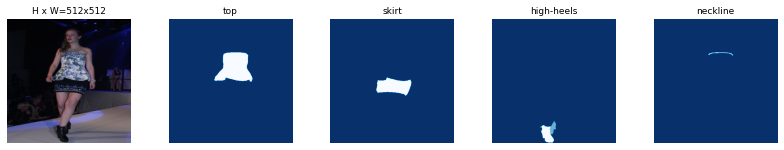

('/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/new_train/037f2d8be68d4cc370b647ef4addb4d7.jpg', ['canvasshoes', 'canvasshoes', 'pants', 'top, t-shirt, sweatshirt', 'sleeve', 'sleeve', 'neckline', 'watch'])


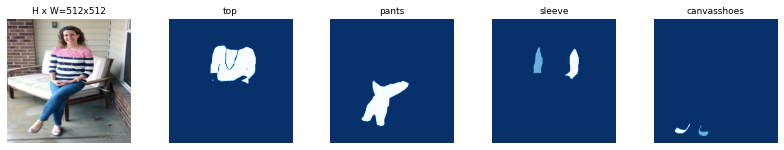

('/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/new_train/03c200ace12c430237613e4ccbf876e5.jpg', ['high-heels', 'skirt', 'top, t-shirt, sweatshirt', 'neckline', 'headband, head covering, hair accessory'])


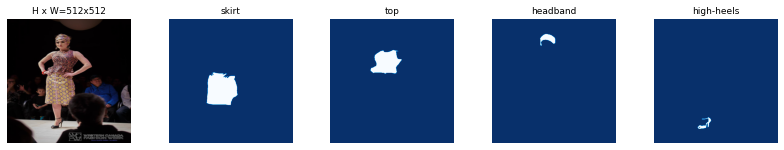

In [ ]:
for i in range(3):
  image_id = random.choice(dataset.image_ids)
  print(dataset.image_reference(image_id))

  image = dataset.load_image(image_id)
  mask, class_ids = dataset.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

ก่อนที่จะเทรน ก็จะทำการแบ่งข้อมูลเป็น training set กับ validation set

In [ ]:
train_df, valid_df = train_test_split(image_df, test_size=0.2, random_state=42)


train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()


เมื่อสร้าง training set และ validation set เสร็จแล้ว ก็จะลองทำ visualization ดูว่า category ต่างๆ มีการกระจายเป็นยังไงบ้าง

Total train images:  166
Total train segments:  1449


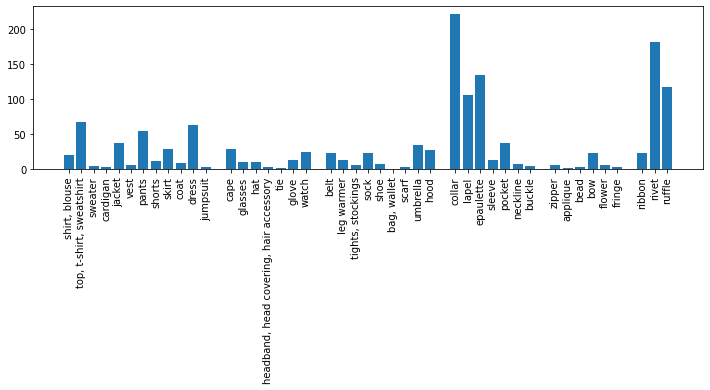

Total validation images:  42
Total validation segments:  357


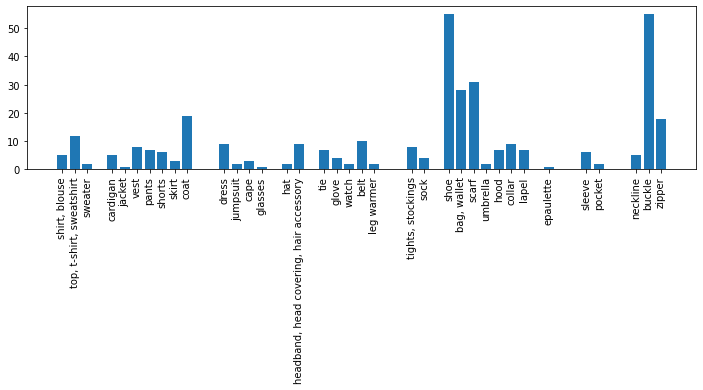

In [ ]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# **5. Train**
ในขั้นแรกของกระบวนการเทรน ก็จะสร้างโมเดล Mask R-CNN จาก config ที่กำหนดไว้ และโหลด pretrained weight มาใส่

In [ ]:
os.getcwd()


'/content/Mask_RCNN'

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir="/content")

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








library นี้ รองรับการทำ augmentation จาก imgaug ด้วย ในที่นี้ได้เพิ่ม augmentation ที่เป็น horizontal flip เข้าไป

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5)
])

ในขั้นแรก จะทำการเทรนเฉพาะส่วนหัวของโมเดลก่อน

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=2e-3,
            epochs=1,
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: /content/fashion20211119T0822/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

แล้วต่อมาจึงค่อยเทรนโมเดลทั้งหมด

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=1e-3,
            epochs=3,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=0.001

Checkpoint Path: /content/fashion20211119T0822/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Ba

ในที่นี้ได้เทรนไปทั้งสิ้นจำนวน 3 รอบ (epoch) เมื่อเทรนเสร็จแล้วก็จะพล็อตกราฟของ loss โดยรวม และ loss ของหัว class กับหัว mask ออกมาดู พร้อมกับเลือกโมเดลในรอบที่ดีที่สุดเพื่อนำไปใช้กับ test data ต่อไป

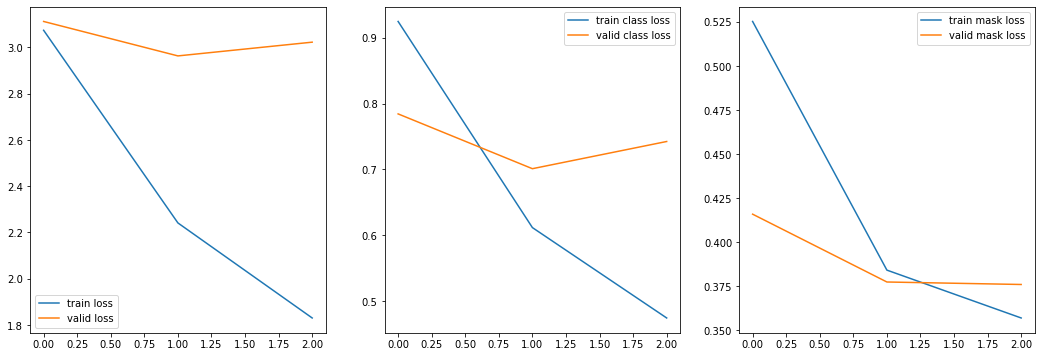

In [ ]:
epochs = range(3)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  2
Valid loss:  2.963453313509623


In [ ]:
best_epoch = np.argmin(history['loss']) + 1
print("Best epoch: ", best_epoch)
print("train loss: ", history['loss'][best_epoch-1])

Best epoch:  3
train loss:  1.830301239490509


# **6. Predict**
ขั้นตอนสุดท้ายก็จะเป็นการนำโมเดลที่เทรนไว้มาใช้ทำนาย test data โดยเริ่มจากการเซ็ตค่า config แล้วโหลดโมเดลที่เทรนไว้ขึ้นมา

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

glob_list = glob.glob(f'/content/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir="./")
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/fashion20211119T0822/mask_rcnn_fashion_0003.h5
Re-starting from epoch 3


แล้วอ่านไฟล์ sample_submission.csv ซึ่งมีชื่อรูปภาพที่จะต้องทำการทดสอบ

In [ ]:
#อีกแบบ
sample_df = pd.read_csv('/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/test_img_me1.csv')
sample_df.head()

,ImageId,EncodedPixels,ClassId
0,06a.jpg,1 1,23
1,08a.jpg,1 1,23
2,01b.jpg,1 1,23
3,06b.jpg,1 1,23
4,04c.jpg,1 1,23


ฟังก์ชัน to_rle เป็นฟังก์ชันที่แปลง mask จากโมเดลเป็น run-length encoding ซึ่งเป็น format ที่ใช้ในการส่งผลลัพธ์

In [ ]:
def to_rle(bits):
    rle = []
    pos = 1
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, len(group_list)])
        pos += len(group_list)
    return rle

นอกจากนี้ ระบบตรวจผลลัพธ์ยังไม่อนุญาตให้ pixel นึง อยู่ใน mask หลายอันที่เป็นคลาสเดียวกัน จึงต้องมีฟังก์ชัน trim_masks เพื่อใช้แก้กรณีนี้

In [ ]:
def trim_masks(masks, rois, class_ids):
    class_pos = np.argsort(class_ids)
    class_rle = to_rle(np.sort(class_ids))

    pos = 0
    for i, _ in enumerate(class_rle[::2]):
        previous_pos = pos
        pos += class_rle[2*i+1]
        if pos-previous_pos == 1:
            continue
        mask_indices = class_pos[previous_pos:pos]

        union_mask = np.zeros(masks.shape[:-1], dtype=bool)
        for m in mask_indices:
            masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
            union_mask = np.logical_or(masks[:, :, m], union_mask)
        for m in mask_indices:
            mask_pos = np.where(masks[:, :, m]==True)
            if np.any(mask_pos):
                y1, x1 = np.min(mask_pos, axis=1)
                y2, x2 = np.max(mask_pos, axis=1)
                rois[m, :] = [y1, x1, y2, x2]

    return masks, rois

ในส่วนนี้ก็จะเป็นการรันเพื่อทำนายผลลัพธ์

'\n%%time\nsub_list = []\nmissing_count = 0\nfor i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):\n    image = resize_image(str("/content/drive/MyDrive/Project Vision/test/" +  row[\'ImageId\']))\n    result = model.detect([image])[0]\n    if result[\'masks\'].size > 0:\n        masks, _ = trim_masks(result[\'masks\'], result[\'rois\'], result[\'class_ids\'])\n        for m in range(masks.shape[-1]):\n            mask = masks[:, :, m].ravel(order=\'F\')\n            rle = to_rle(mask)\n            label = result[\'class_ids\'][m] - 1\n            sub_list.append([row[\'ImageId\'], \' \'.join(list(map(str, rle))), label])\n    else:\n        # The system does not allow missing ids, this is an easy way to fill them\n        sub_list.append([row[\'ImageId\'], \'1 1\', 23])\n        missing_count += 1\n'

In [ ]:
#อีกแบบ
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str("/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/test_img/" +  row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = trim_masks(result['masks'], result['rois'], result['class_ids'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

100%|██████████| 24/24 [00:47<00:00,  1.98s/it]

CPU times: user 16.2 s, sys: 1.31 s, total: 17.5 s
Wall time: 47.5 s


เมื่อได้ผลลัพธ์ออกมาแล้ว ก็จะนำมาสร้างเป็นไฟล์สำหรับส่งตรวจ

In [ ]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing images: ", missing_count)
submission_df.head()

Total image results:  24
Missing images:  0


,ImageId,EncodedPixels,ClassId
0,06a.jpg,72441 24 72942 45 73452 52 73964 54 74476 56 7...,6
1,06a.jpg,95677 9 96189 12 96227 3 96702 44 97215 44 977...,48
2,06a.jpg,135321 10 135813 3 135822 34 136304 7 136322 5...,31
3,06a.jpg,53987 7 54496 14 55001 25 55505 38 56010 49 56...,31
4,06a.jpg,128973 8 129481 14 129990 18 130501 20 131007 ...,48


In [ ]:
submission_df.to_csv("submission_BAMต้องรอด.csv", index=False)

สุดท้ายนี้ ลองมาดูผลลัพธ์ที่ได้กันซักหน่อยครับ จะเห็นว่าไม่เลวเลยทีเดียว แม้จะยังมีที่ผิดอยู่ก็ตาม

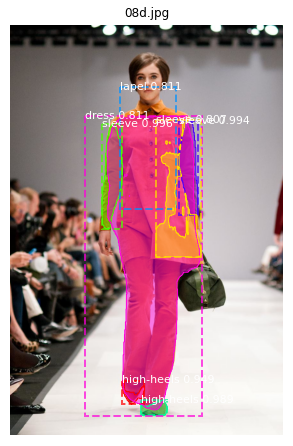

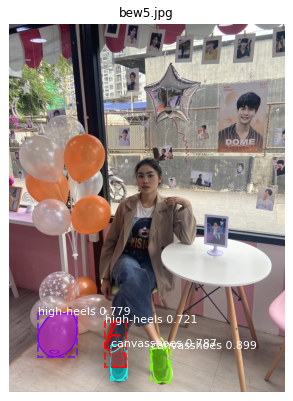

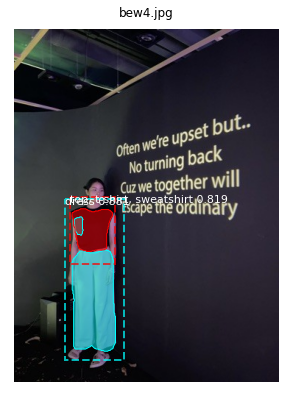

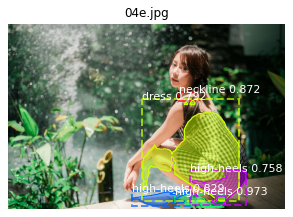

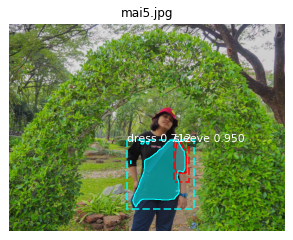

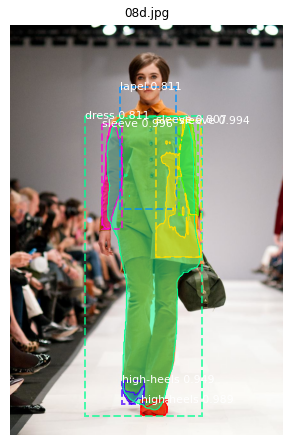

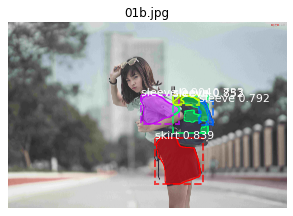

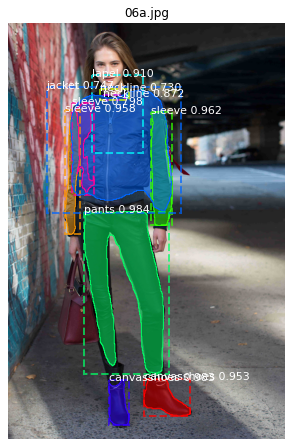

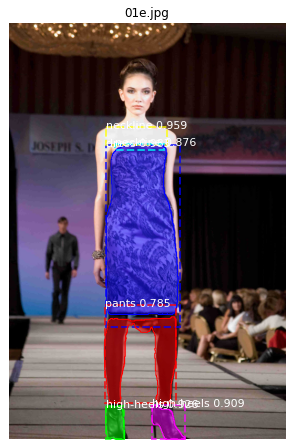

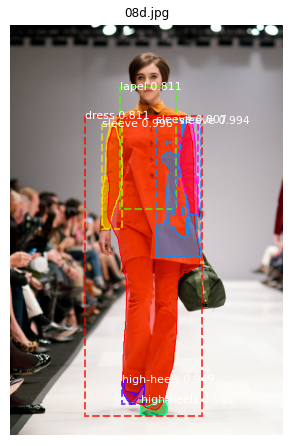

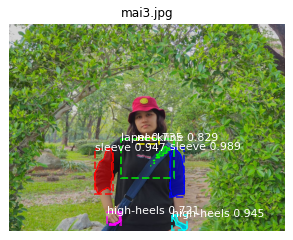

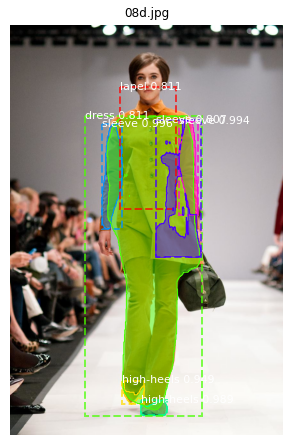

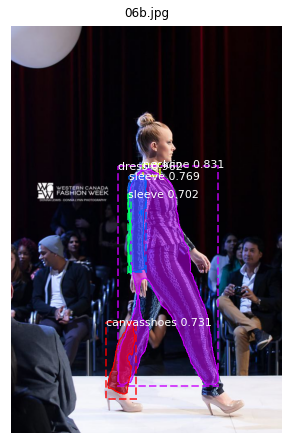

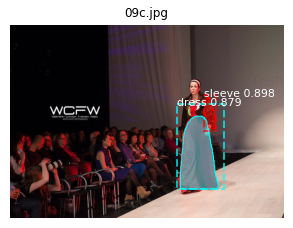

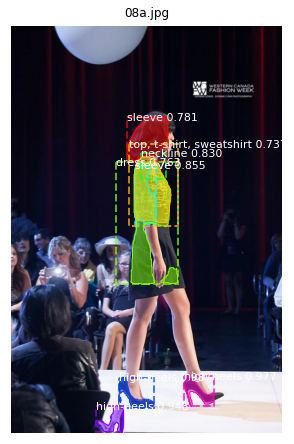

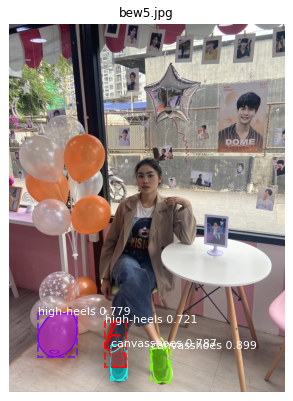

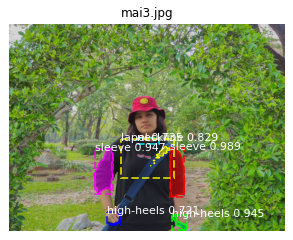

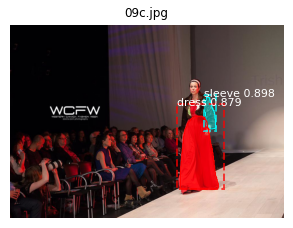

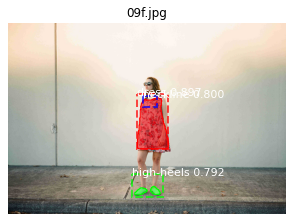

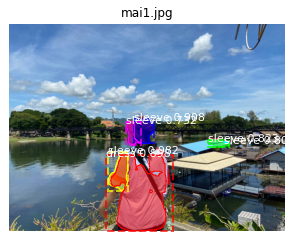

In [ ]:
#อีกแบบ
for i in range(20):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str('/content/drive/MyDrive/Project Vision/CP461_1-11-64/source code ของการทำโปรเจค/ชุดข้อมูลใหม่/test_img/'+ image_id)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = model.detect([resize_image(image_path)])
    r = result[0]

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'),
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

        masks, rois = trim_masks(masks, rois, r['class_ids'])
    else:
        masks, rois = r['masks'], r['rois']


    visualize.display_instances(img, rois, masks, r['class_ids'],
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(5, 8))

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap, compute_recall
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image


In [ ]:
def evaluate_model(dataset, model, cfg):
  APs = list();
  F1_scores = list();

  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    scaled_image = mold_image(image, cfg)
    sample = expand_dims(scaled_image, 0)

    yhat = model.detect(sample, verbose=0)
    r = yhat[0]
    AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

    F1_scores.append((2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls)))
    APs.append(AP)

    mAP = mean(APs)
    F1  = mean(F1_scores)
    precision = mean(precisions)
    recall = mean(recalls)

  return mAP, F1 ,precision,recall,F1_scores

In [ ]:

cfg = FashionConfig()
mAP, F1 ,precision,recall,F1_scores = evaluate_model(dataset, model, cfg)
print("mAP: %.3f" % mAP)
print("mean f1-score: ", F1_scores)



mAP: 0.250
mean f1-score:  [0.3835978835978836, 0.0, 0.35511491827335523, 0.5329991645781119, 0.4065040682724856, 0.0, 0.37988827154340304, 0.37978381974773, 0.19900497570528772, 0.594609466204596, 0.6163697189477441, 0.2567567567567568, 0.2523584905660377, 0.587196475462119, 0.4893939393939394, 0.0, 0.5491873413542808, 0.42978003855935876, 0.3455973141073705, 0.4819126074498567, 0.43264503890619616, 0.4894543787253553, 0.4434782631968505, 0.0, 0.0, 0.0, 0.48387097213785557, 0.514488173065056, 0.5143824069117819, 0.46235805843548844, 0.42978003855935876, 0.15195091603565458, 0.4322033922576726, 0.4384615384615385, 0.5240071179757616, 0.3087719311564473, 0.4432624113475177, 0.6250000058207661, 0.0, 0.5436621790627529, 0.4444444479765715, 0.5123239462694348, 0.40874317198321664, 0.29729729729729726, 0.41698842038910977, 0.2011494257303159, 0.4973876756979263, 0.4922935410804664, 0.38243913682236913, 0.23786407805703955, 0.25212314225053073, 0.46666666747381297, 0.2567567567567568, 0.4090

In [ ]:
mAP, F1 ,precision,recall,F1_scores = evaluate_model(dataset, model, cfg)
print("mAP: %.3f" % mAP)
print("F1: %.3f" % F1)
print("precision: %.3f" % precision)
print("recall: %.3f" % recall)

mAP: 0.250
F1: 0.360
precision: 0.000
recall: 0.200
